In [ ]:
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM, Conv1D, RNN, SimpleRNN
from tensorflow.keras.layers import GlobalMaxPooling1D, Bidirectional 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Bidirectional
from sklearn import preprocessing
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
import re
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
np.random.seed(42)

In [ ]:
from google.colab import files
uploaded = files.upload()
name = list(uploaded.keys())
print(name[0])

Saving 12-03-20231.csv to 12-03-20231.csv
12-03-20231.csv


In [ ]:
df = pd.read_csv('/content/12-03-20231.csv')
df.head()

,Time (IST),Latitude,Longitude,Course,kts,mph,meters,Rate,Reporting Facility,Time Diff,m/s,Dist from lp,tilt
0,NaN,17.228065,78.415484,88.0,172.0,3.197442e-14,626.406637,0.0,NaN,0.0,1.421085e-14,0.0,0.0
1,NaN,17.228067,78.415525,88.0,172.0,1.980000e+01,626.406637,0.0,NaN,1.0,8.800000e+00,4.4,0.0
2,NaN,17.228071,78.415650,88.0,172.0,3.960000e+01,626.406637,0.0,NaN,1.0,1.760000e+01,13.2,0.0
3,NaN,17.228078,78.415857,88.0,172.0,5.940000e+01,626.406637,0.0,NaN,1.0,2.640000e+01,22.0,0.0
4,NaN,17.228087,78.416146,88.0,172.0,7.920000e+01,626.406637,0.0,NaN,1.0,3.520000e+01,30.8,0.0


In [ ]:
df.fillna(value='', inplace=True)

In [ ]:
data=np.array(df)
print(data.shape)

(242, 13)


In [ ]:
dataX = np.array(df[['Course','kts','mph','meters','Rate','m/s','Dist from lp','tilt']])
dataY = data[:,1:3]

min_max_scaler = preprocessing.MinMaxScaler()
dataX = min_max_scaler.fit_transform(dataX)

In [ ]:
split = 160
dataXt = dataX[:split]
dataYt = dataY[:split]
dataXv = dataX[split:]
dataYv = dataY[split:]

input_dim = dataXt.shape[1]

print("input_dim:", input_dim)
print("Training ",dataXt.shape[0])
print("Testing",dataXv.shape[0])

input_dim: 8
Training  160
Testing 82


In [ ]:
timestep = 2
Xphithetapsi = dataXt
dataXt = np.asarray(dataXt).astype('float32').reshape(split//timestep, timestep, input_dim)
dataYt = np.asarray(dataYt[0::timestep]).astype('float32')

dataXv = array(dataXv).reshape(dataXv.shape[0]//timestep, timestep, input_dim)
dataYv = array(dataYv[0::timestep])

In [ ]:
inputs = Input(name='inputs',shape=[timestep,input_dim])
layer = LSTM(41, return_sequences=True)(inputs)
layer = Dropout(0.25)(layer)
layer = LSTM(41)(layer)
outputs = Dense(2, activation='linear')(layer)

orientationModel = Model(inputs=[inputs],outputs=[outputs])

# Compile
orientationModel.compile(optimizer='RMSprop', loss='mean_squared_error',metrics = ['accuracy'])
orientationModel.summary()

history = orientationModel.fit(dataXt, dataYt,
                       epochs=20,
                       verbose=0,
                       batch_size=50)

print('Model Training done')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 2, 8)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 2, 41)             8200      
                                                                 
 dropout_6 (Dropout)         (None, 2, 41)             0         
                                                                 
 lstm_13 (LSTM)              (None, 41)                13612     
                                                                 
 dense_6 (Dense)             (None, 2)                 84        
                                                                 
Total params: 21,896
Trainable params: 21,896
Non-trainable params: 0
_________________________________________________________________
Model Training done


In [ ]:

test_output = orientationModel.predict(dataXv)
test_output = array(test_output)

results = np.array(test_output)
results = results.reshape(dataXv.shape[0],2)
print(results.shape)

2/2 [==============================] - 1s 6ms/step
(41, 2)


RMSE lat 17.210218258115898
RMSE long 68.56499770719039
17.210218258115898 68.56499770719039


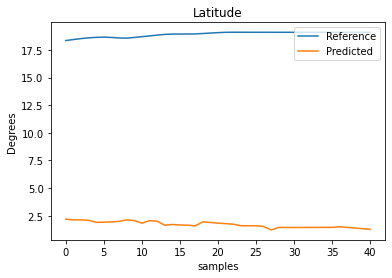

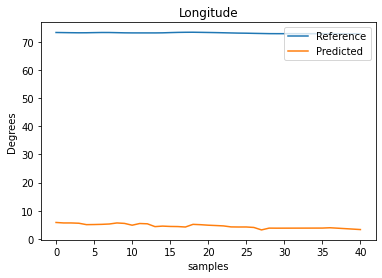

In [ ]:
rmselat = sqrt(mean_squared_error(dataYv[:,0], results[:,0]))
print("RMSE lat",rmselat)

rmselong = sqrt(mean_squared_error(dataYv[:,1], results[:,1]))
print("RMSE long",rmselong)


print(rmselat,rmselong)

plt.plot(dataYv[:,0])
plt.plot(results[:,0])
plt.title('Latitude')
plt.xlabel('samples')
plt.ylabel('Degrees')
plt.legend(['Reference', 'Predicted'], loc = 'upper right')
plt.show()

plt.plot(dataYv[:,1])
plt.plot(results[:,1])
plt.title('Longitude')
plt.xlabel('samples')
plt.ylabel('Degrees')
plt.legend(['Reference', 'Predicted'], loc = 'upper right')
plt.show()

In [ ]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
 X, y = list(), list()
 for i in range(len(sequences)):
 # find the end of this pattern
  end_ix = i + n_steps
  # check if we are beyond the dataset
  if end_ix > len(sequences)-1:
    break
  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
  X.append(seq_x)
  y.append(seq_y)
  return array(X), array(y)
 
# define input sequence
in_seq1 = array(df['Latitude'][:160])
in_seq2 = array(df['Longitude'][:160])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2))
# choose a number of time steps
n_steps = 10
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=400, verbose=0)
# demonstrate prediction
x_input = array([[df['Latitude'][160], df['Longitude'][160]], [df['Latitude'][161], df['Longitude'][161]],
                 [df['Latitude'][162], df['Longitude'][162]],[df['Latitude'][163], df['Longitude'][163]],
                 [df['Latitude'][164], df['Longitude'][164]],[df['Latitude'][165], df['Longitude'][165]],
                 [df['Latitude'][166], df['Longitude'][166]],[df['Latitude'][167], df['Longitude'][167]],
                 [df['Latitude'][168], df['Longitude'][168]],[df['Latitude'][169], df['Longitude'][169]]]).astype('float32')
x_input = array(x_input).reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[14.884116 72.438675]]


In [ ]:
print([df['Latitude'][170], df['Longitude'][170]])

[18.6506, 73.2583]


In [ ]:
print([df['Latitude'][161], df['Longitude'][161]])

[18.3868, 73.2836]


## Final Implementation

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [163]:
from glob import glob
csvs = glob('/content/*.csv')
csv_list = [csv[:-5] for csv in csvs]
csv_list.sort()

In [164]:
datelist = []
for i in csv_list:
  daynum = i[9:11]
  datelist.append(int(daynum))
print(datelist)

[12, 13, 14, 15, 16]


In [165]:
dataframelist = []
for i in csv_list:
  df_new = pd.read_csv(i+'1.csv')
  df_new = df_new.dropna(subset=['Time (IST)']).reset_index(drop=True)
  daylist = np.array(df_new['Time (IST)'])
  strday = daylist[0][:3]
  df_new['date_time'] = ''
  for j in range(df_new.shape[0]):
    day2 = daylist[j][:3]
    if(strday==day2):
      df_new['date_time'][j] = i[9:] + daylist[j][3:]
    else:
      df_new['date_time'][j] = str(int(i[9:11]) + 1) + i[11:] + daylist[j][3:]
  dataframelist.append(df_new)

In [171]:
for df in dataframelist:
  df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M:%S')
  df['day'] = df['date_time'].apply(lambda x: x.day)
  df['hour'] = df['date_time'].apply(lambda x: x.hour)
  df['minute'] = df['date_time'].apply(lambda x: x.minute)
  df['second'] = df['date_time'].apply(lambda x: x.second)

## For Latitude

In [172]:
df_update = dataframelist[0].loc[:,['date_time','Latitude', 'day', 'hour','minute','second']]
for df in dataframelist[1:]:
  df_lat=df.loc[:,['date_time','Latitude', 'day', 'hour','minute','second']]
  df_update = pd.concat([df_update, df_lat], axis=0)
df_update

,date_time,Latitude,day,hour,minute,second
0,2023-03-12 22:47:37,17.2295,12,22,47,37
1,2023-03-12 22:48:07,17.2297,12,22,48,7
2,2023-03-12 22:48:27,17.2313,12,22,48,27
3,2023-03-12 22:48:46,17.2436,12,22,48,46
4,2023-03-12 22:49:06,17.2665,12,22,49,6
...,...,...,...,...,...,...
200,2023-03-17 00:08:02,19.0898,17,0,8,2
201,2023-03-17 00:08:12,19.0898,17,0,8,12
202,2023-03-17 00:09:12,19.0892,17,0,9,12
203,2023-03-17 00:09:28,19.0890,17,0,9,28


In [173]:
stat, p = stats.normaltest(df_update.Latitude)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=5080.954, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.2651493306404284
Skewness of normal distribution: 0.2258425477058519


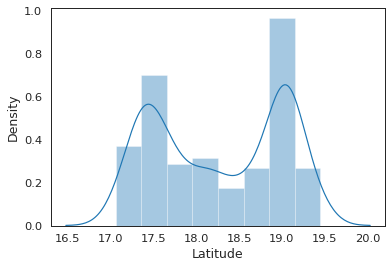

In [174]:
sns.distplot(df_update.Latitude);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_update.Latitude)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_update.Latitude)))

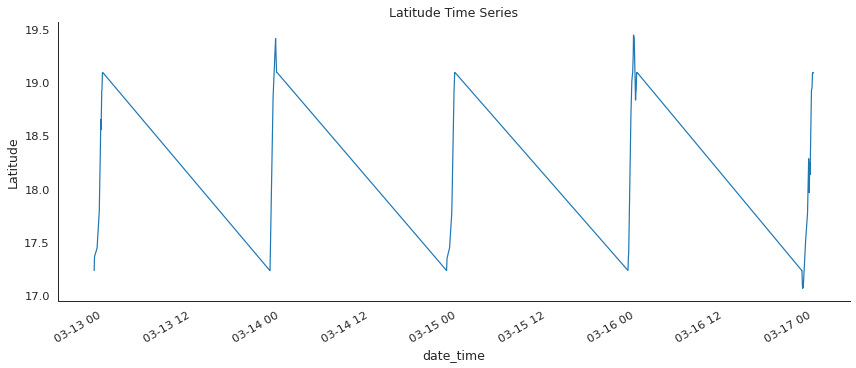

In [175]:
dfspec=df_update.loc[:,['date_time','Latitude']]
dfspec.set_index('date_time',inplace=True)
dfspec.plot(figsize=(12,5))
plt.ylabel('Latitude')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Latitude Time Series')
sns.despine(top=True)
plt.show();

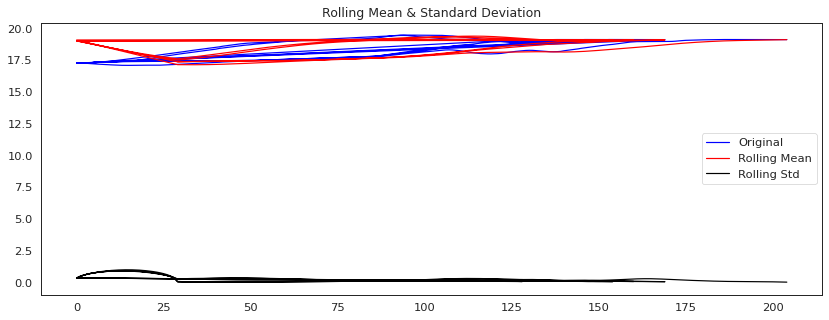

<Results of Dickey-Fuller Test>
Test Statistic                 -2.6094
p-value                         0.0911
#Lags Used                      0.0000
Number of Observations Used   819.0000
Critical Value (1%)            -3.4384
Critical Value (5%)            -2.8651
Critical Value (10%)           -2.5687
dtype: float64


In [179]:
df2=df_update.copy()
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Latitude.dropna())

In [180]:
dataset = df_update.Latitude.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test_size = dataframelist[-1].shape[0]
train_size = len(dataset) - test_size
train, test = dataset[:train_size,:], dataset[train_size:,:]

def create_dataset(dataset, look_back, look_ahead):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_ahead):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back + look_ahead - 1, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
look_ahead = 1
X_train, Y_train = create_dataset(train, look_back, look_ahead)
X_test, Y_test = create_dataset(test, look_back, look_ahead)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [181]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

model.summary()

Epoch 1/15
13/13 [==============================] - 3s 49ms/step - loss: 0.2467 - val_loss: 0.0770
Epoch 2/15
13/13 [==============================] - 0s 9ms/step - loss: 0.0503 - val_loss: 0.0056
Epoch 3/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0048
Epoch 4/15
13/13 [==============================] - 0s 8ms/step - loss: 0.0183 - val_loss: 0.0027
Epoch 5/15
13/13 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0032
Epoch 6/15
13/13 [==============================] - 0s 8ms/step - loss: 0.0148 - val_loss: 0.0028
Epoch 7/15
13/13 [==============================] - 0s 9ms/step - loss: 0.0137 - val_loss: 0.0023
Epoch 8/15
13/13 [==============================] - 0s 9ms/step - loss: 0.0132 - val_loss: 0.0022
Epoch 9/15
13/13 [==============================] - 0s 8ms/step - loss: 0.0133 - val_loss: 0.0022
Epoch 10/15
13/13 [==============================] - 0s 7ms/step - loss: 0.0129 - val_loss: 0.0021
Epoch 11/15
13/13 

In [182]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

7/7 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 0.10826381556362517
Train Root Mean Squared Error: 0.232593163700124
Test Mean Absolute Error: 0.07452346298403241
Test Root Mean Squared Error: 0.09151393836972299


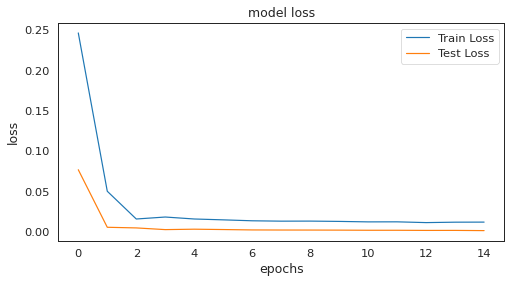

In [183]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

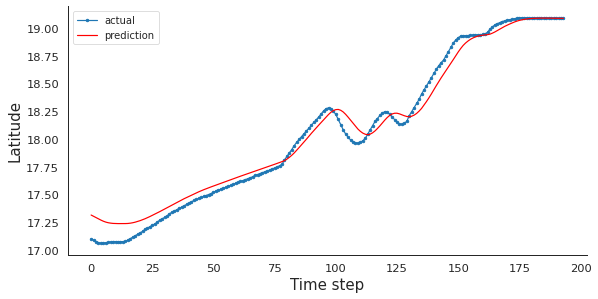

In [184]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Latitude', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();

## For Longitude

In [185]:
df_update = dataframelist[0].loc[:,['date_time','Longitude', 'day', 'hour','minute','second']]
for df in dataframelist[1:]:
  df_long=df.loc[:,['date_time','Longitude', 'day', 'hour','minute','second']]
  df_update = pd.concat([df_update, df_long], axis=0)
df_update

,date_time,Longitude,day,hour,minute,second
0,2023-03-12 22:47:37,78.4585,12,22,47,37
1,2023-03-12 22:48:07,78.4863,12,22,48,7
2,2023-03-12 22:48:27,78.5084,12,22,48,27
3,2023-03-12 22:48:46,78.5293,12,22,48,46
4,2023-03-12 22:49:06,78.5394,12,22,49,6
...,...,...,...,...,...,...
200,2023-03-17 00:08:02,72.9515,17,0,8,2
201,2023-03-17 00:08:12,72.9443,17,0,8,12
202,2023-03-17 00:09:12,72.8994,17,0,9,12
203,2023-03-17 00:09:28,72.8878,17,0,9,28


In [186]:
stat, p = stats.normaltest(df_update.Longitude)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=641.961, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.2051496435732894
Skewness of normal distribution: 0.5453027259832648


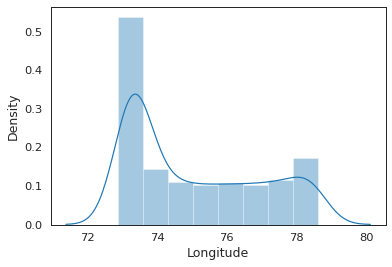

In [187]:
sns.distplot(df_update.Longitude);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_update.Longitude)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_update.Longitude)))

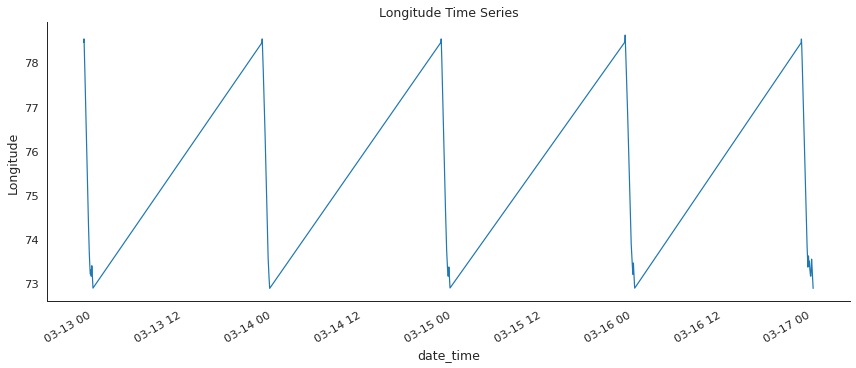

In [188]:
dfspec=df_update.loc[:,['date_time','Longitude']]
dfspec.set_index('date_time',inplace=True)
dfspec.plot(figsize=(12,5))
plt.ylabel('Longitude')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Longitude Time Series')
sns.despine(top=True)
plt.show();

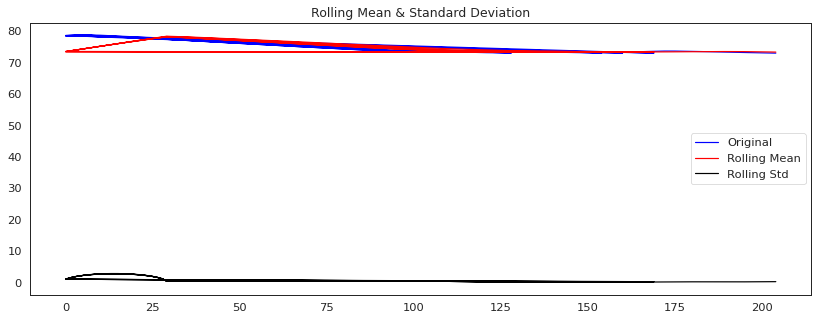

<Results of Dickey-Fuller Test>
Test Statistic                 -3.1293
p-value                         0.0245
#Lags Used                      0.0000
Number of Observations Used   819.0000
Critical Value (1%)            -3.4384
Critical Value (5%)            -2.8651
Critical Value (10%)           -2.5687
dtype: float64


In [189]:
df2=df_update.copy()
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Longitude)

In [257]:
dataset = df_update.Longitude.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test_size = dataframelist[-1].shape[0]
train_size = len(dataset) - test_size
train, test = dataset[:train_size,:], dataset[train_size:,:]

def create_dataset(dataset, look_back, look_ahead):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_ahead):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back + look_ahead - 1, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
look_ahead = 1
X_train, Y_train = create_dataset(train, look_back, look_ahead)
X_test, Y_test = create_dataset(test, look_back, look_ahead)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [258]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

model.summary()

Epoch 1/15
19/19 [==============================] - 4s 33ms/step - loss: 0.1208 - val_loss: 0.0117
Epoch 2/15
19/19 [==============================] - 0s 7ms/step - loss: 0.0261 - val_loss: 0.0064
Epoch 3/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0224 - val_loss: 0.0038
Epoch 4/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0192 - val_loss: 0.0024
Epoch 5/15
19/19 [==============================] - 0s 7ms/step - loss: 0.0187 - val_loss: 0.0021
Epoch 6/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0177 - val_loss: 0.0016
Epoch 7/15
19/19 [==============================] - 0s 7ms/step - loss: 0.0167 - val_loss: 0.0013
Epoch 8/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0167 - val_loss: 9.9443e-04
Epoch 9/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0149 - val_loss: 8.6326e-04
Epoch 10/15
19/19 [==============================] - 0s 6ms/step - loss: 0.0143 - val_loss: 6.7966e-04
Epoch 

In [259]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

7/7 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 0.17650088948932274
Train Root Mean Squared Error: 0.5688712342899975
Test Mean Absolute Error: 0.09167581693213628
Test Root Mean Squared Error: 0.11138536933231225


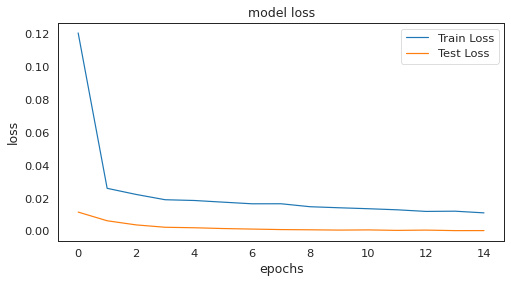

In [260]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

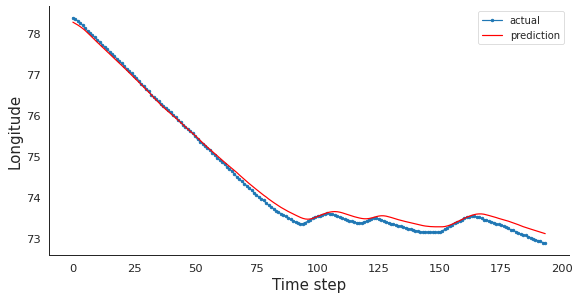

In [261]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:][:,0], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Longitude', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();

## Altitude

In [262]:
df_update = dataframelist[0].loc[:,['date_time','meters', 'day', 'hour','minute','second']]
for df in dataframelist[1:]:
  df_alt=df.loc[:,['date_time','meters', 'day', 'hour','minute','second']]
  df_update = pd.concat([df_update, df_alt], axis=0)
df_update

,date_time,meters,day,hour,minute,second
0,2023-03-12 22:47:37,815.0000,12,22,47,37
1,2023-03-12 22:48:07,1036.0000,12,22,48,7
2,2023-03-12 22:48:27,1212.0000,12,22,48,27
3,2023-03-12 22:48:46,1433.0000,12,22,48,46
4,2023-03-12 22:49:06,1745.0000,12,22,49,6
...,...,...,...,...,...,...
200,2023-03-17 00:08:02,450.0000,17,0,8,2
201,2023-03-17 00:08:12,404.0000,17,0,8,12
202,2023-03-17 00:09:12,160.0000,17,0,9,12
203,2023-03-17 00:09:28,107.0000,17,0,9,28


In [263]:
stat, p = stats.normaltest(df_update.meters)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=6837.796, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.4740191352184537
Skewness of normal distribution: -0.17238728218291083


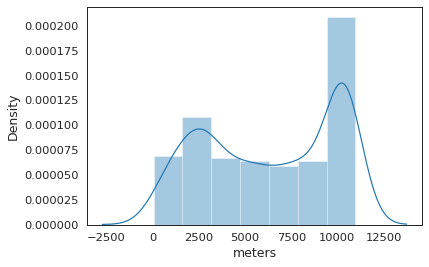

In [264]:
sns.distplot(df_update.meters);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df_update.meters)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df_update.meters)))

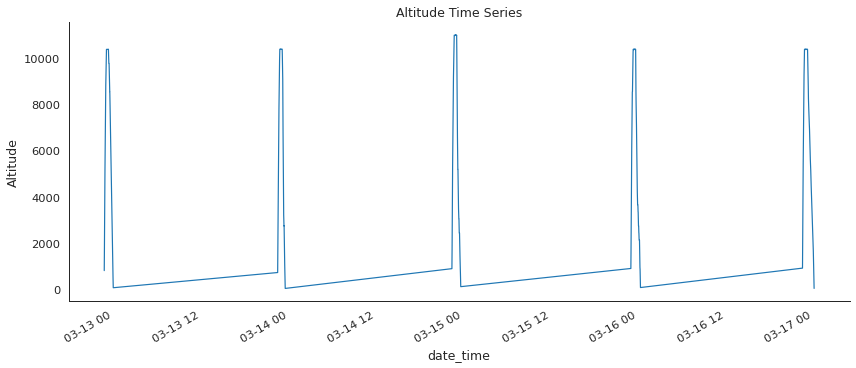

In [265]:
dfspec=df_update.loc[:,['date_time','meters']]
dfspec.set_index('date_time',inplace=True)
dfspec.plot(figsize=(12,5))
plt.ylabel('Altitude')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Altitude Time Series')
sns.despine(top=True)
plt.show();

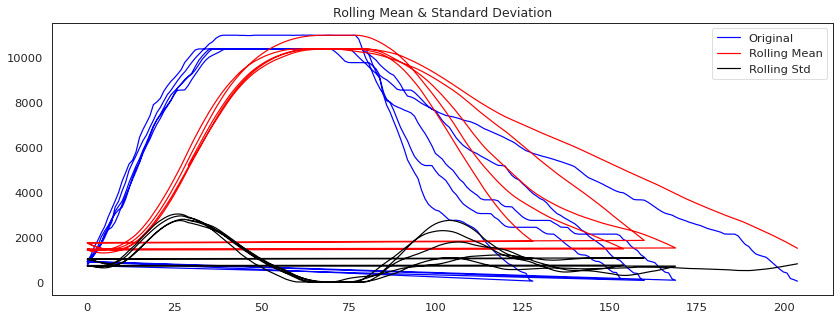

<Results of Dickey-Fuller Test>
Test Statistic                 -4.5202
p-value                         0.0002
#Lags Used                      4.0000
Number of Observations Used   815.0000
Critical Value (1%)            -3.4384
Critical Value (5%)            -2.8651
Critical Value (10%)           -2.5687
dtype: float64


In [266]:
df2=df_update.copy()
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.meters)

In [305]:
dataset = df_update.meters.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
test_size = dataframelist[-1].shape[0]
train_size = len(dataset) - test_size
train, test = dataset[:train_size,:], dataset[train_size:,:]

def create_dataset(dataset, look_back, look_ahead):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_ahead):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back + look_ahead - 1, 0])
    return np.array(X), np.array(Y)
    
look_back = 5
look_ahead = 1
X_train, Y_train = create_dataset(train, look_back, look_ahead)
X_test, Y_test = create_dataset(test, look_back, look_ahead)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [306]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

'''
Note that Dickey-Fuller Test suggests the greatest amount of stochasticity for 
altitude, hence we should use a smaller batch_size or more epochs for higher
accuracy when training, also ensuring validation loss is not increasing to
avoid overfitting.
''' 


history = model.fit(X_train, Y_train, epochs=15, batch_size=16, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

model.summary()

Epoch 1/15
39/39 [==============================] - 5s 29ms/step - loss: 0.2272 - val_loss: 0.0341
Epoch 2/15
39/39 [==============================] - 0s 11ms/step - loss: 0.0167 - val_loss: 0.0056
Epoch 3/15
39/39 [==============================] - 0s 8ms/step - loss: 0.0078 - val_loss: 0.0040
Epoch 4/15
39/39 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 5/15
39/39 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 6/15
39/39 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 7/15
39/39 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 8/15
39/39 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 9/15
39/39 [==============================] - 0s 7ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 10/15
39/39 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 11/15
39/39

In [307]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

7/7 [==============================] - 0s 3ms/step
Train Mean Absolute Error: 371.9035032142973
Train Root Mean Squared Error: 495.4816369354747
Test Mean Absolute Error: 258.2453976834592
Test Root Mean Squared Error: 409.3650196059299


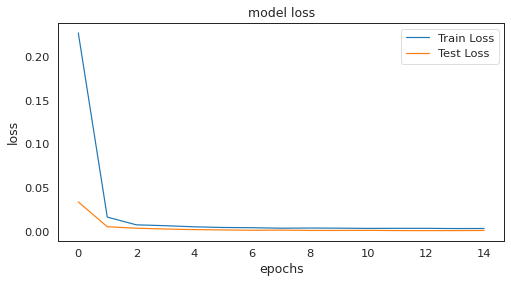

In [308]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

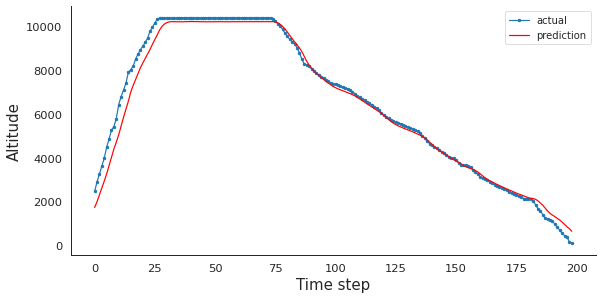

In [309]:
aa=[x for x in range(Y_test.shape[1])]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:][:,0], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Altitude', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show();